In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
import pandas as pd


EI_df = pd.read_csv('./MBTI_PJ.csv')
#PJ_df = pd.read_csv('/content/drive/MyDrive/4-1/인공신경망과 딥러닝/팀플/dataset/MBTI_PJ.csv')
#SN_df = pd.read_csv('/content/drive/MyDrive/4-1/인공신경망과 딥러닝/팀플/dataset/MBTI_SN.csv')
#TF_df = pd.read_csv('/content/drive/MyDrive/4-1/인공신경망과 딥러닝/팀플/dataset/MBTI_TF.csv')
EI_df.head(10)


SEED = 5
random.seed(SEED)
torch.manual_seed(SEED)

BATCH_SIZE = 64
lr = 0.001
EPOCHS = 10

USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
print("cpu와 cuda 중 다음 기기로 학습함:", DEVICE)

cpu와 cuda 중 다음 기기로 학습함: cpu


In [4]:
from sklearn.model_selection import train_test_split

value_list=[]
for i in EI_df.wordvalue:
    ss=i.strip("'[").strip("]'").split(", ")
    sss=[]
    for j in ss:
        sss.append(int(j))
    value_list.append(sss)

X = torch.tensor(value_list)
y = torch.tensor(EI_df['type'].values)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size = 0.5, random_state=42)

Text(0.5, 1.0, 'Count of types')

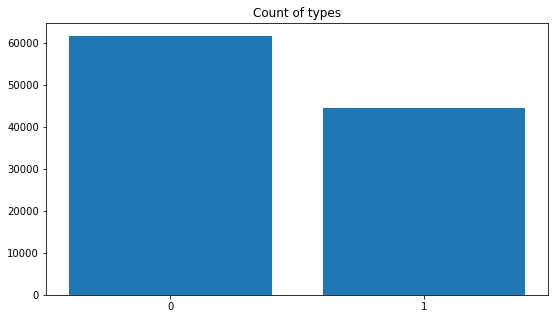

In [5]:
import numpy as np
import matplotlib.pyplot as plt

unique_labels, count = np.unique(EI_df['type'], return_counts=True)
fig = plt.figure(figsize=(9,5))
plt.xticks(np.arange(0,2,1))
plt.bar(unique_labels, count, width=0.8)
plt.title("Count of types")

In [11]:
from torch.utils.data import TensorDataset # 텐서데이터셋
from torch.utils.data import DataLoader # 데이터로더

train_dataset = TensorDataset(X_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE,  shuffle=True)

val_dataset = TensorDataset(X_val, y_val)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE,  shuffle=True)

test_dataset = TensorDataset(X_test, y_test)
test_dataloader = DataLoader(test_dataset, batch_size=int(X_test.size()[0]/10),  shuffle=True)

In [12]:
class GRU(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim,dropout_p):
        super(GRU, self).__init__()
        self.n_layers = 1
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.dropout = nn.Dropout(dropout_p)
        self.gru = nn.GRU(embedding_dim, hidden_dim,
                          batch_first=True)
        self.out = nn.Linear(hidden_dim, output_dim)
        self.hidden_dim = hidden_dim
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):

        x = self.embedding(x)

        h_0 = self._init_state(batch_size=x.size(0)) # 첫번째 히든 스테이트를 0벡터로 초기화

        x, _ = self.gru(x, h_0)  # GRU의 리턴값은 (배치 크기, 시퀀스 길이, 은닉 상태의 크기)

        h_t = x[:,-1,:] # (배치 크기, 은닉 상태의 크기)의 텐서로 크기가 변경됨. 즉, 마지막 time-step의 은닉 상태만 가져온다.
        self.dropout(h_t)
        logit = self.out(h_t)  # (배치 크기, 은닉 상태의 크기) -> (배치 크기, 출력층의 크기)
        return self.sigmoid(logit)

    def _init_state(self, batch_size=1):
        weight = next(self.parameters()).data
        return weight.new(self.n_layers, batch_size, self.hidden_dim).zero_()


In [19]:
INPUT_DIM = 3771 
EMBEDDING_DIM = 100
HIDDEN_DIM = 256
OUTPUT_DIM = 1
DROPOUT_PROB = 0.2

model = GRU(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, DROPOUT_PROB)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)



In [20]:
loss_list = []

def binary_accuracy(preds, y):

  rounded_preds = torch.round(torch.sigmoid(preds))
  # rounded_preds : [batch size]
  # y : batch.label
  correct = (rounded_preds == y).float() ## 여기 argmax 바꼈습니다
  acc = correct.sum() / len(correct)
  return acc

def train(model, optimizer, train_iter):
    model.train()
    for b, batch in enumerate(train_iter):
        x, y = batch
        optimizer.zero_grad()
        y = y.squeeze(0)
        logit = model(x)
        y = y.unsqueeze(1)
        #loss = F.cross_entropy(logit, y)
        loss = F.binary_cross_entropy(logit,y.float())
        loss_list.append(loss)
        loss.backward()
        if(b%100==0):
          print("batch-", b, " loss-" , loss.item())
        optimizer.step()


def evaluate(model, val_iter):
    """evaluate model"""
    model.eval()
    corrects, total_loss = 0, 0
    for batch in val_iter:
        x, y = batch
        y = y.squeeze(0)
        logit = model(x)
        y = y.unsqueeze(1)
        #loss = F.cross_entropy(logit, y, reduction='sum')
        loss = F.binary_cross_entropy(logit,y.float())
        total_loss += loss.item()
        corrects +=  binary_accuracy(logit, y.float())
    size = len(val_iter.dataset)
    avg_loss = total_loss / size
    avg_accuracy = 100.0 * corrects / size
    return avg_loss, avg_accuracy

In [21]:
import time
def epoch_time(start_time, end_time):
  elapsed_time = end_time - start_time
  elapsed_mins = int(elapsed_time / 60)
  elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
  return elapsed_mins, elapsed_secs

best_val_loss = None
for e in range(1, 6):

    start_time = time.time()
    

    train(model, optimizer, train_dataloader)
    val_loss, val_accuracy = evaluate(model, val_dataloader)

    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    print("[Epoch: %d] val loss : %5.2f | val accuracy : %5.2f" % (e, val_loss, val_accuracy))
    print(f'Epoch: {e:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')

    # 검증 오차가 가장 적은 최적의 모델을 저장
    if not best_val_loss or val_loss < best_val_loss:
        if not os.path.isdir("snapshot"):
            os.makedirs("snapshot")
        torch.save(model.state_dict(), './snapshot/txtclassification.pt')
        best_val_loss = val_loss

best_valid_loss = float('inf')

# for epoch in range(5):
#     print(model)
#     train_loss, train_acc = train(model, optimizer, train_dataloader)
#     valid_loss, valid_acc = evaluate(model, test_dataloader)
    
    
#     if valid_loss < best_valid_loss:
#         best_valid_loss = valid_loss
#         torch.save(model.state_dict(), 'tut1-model.pt')
    
#     print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
#     print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

batch- 0  loss- 0.6946941614151001
batch- 100  loss- 0.7506027817726135
batch- 200  loss- 0.6694017052650452
batch- 300  loss- 0.6832201480865479
batch- 400  loss- 0.7175562381744385
batch- 500  loss- 0.6938930749893188
batch- 600  loss- 0.48755592107772827
batch- 700  loss- 0.4380837678909302
batch- 800  loss- 0.4421384930610657
batch- 900  loss- 0.3857576549053192
[Epoch: 1] val loss :  0.01 | val accuracy :  0.65
Epoch: 01 | Epoch Time: 36m 30s
batch- 0  loss- 0.4221137762069702
batch- 100  loss- 0.4172070324420929
batch- 200  loss- 0.4139769673347473
batch- 300  loss- 0.2531861364841461
batch- 400  loss- 0.33370593190193176
batch- 500  loss- 0.21907226741313934
batch- 600  loss- 0.31195077300071716
batch- 700  loss- 0.22638557851314545
batch- 800  loss- 0.35345596075057983
batch- 900  loss- 0.24018117785453796
[Epoch: 2] val loss :  0.01 | val accuracy :  0.65
Epoch: 02 | Epoch Time: 52m 55s
batch- 0  loss- 0.2980586886405945
batch- 100  loss- 0.31087592244148254
batch- 200  loss- 

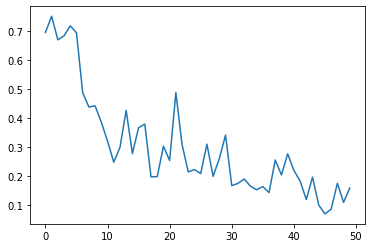

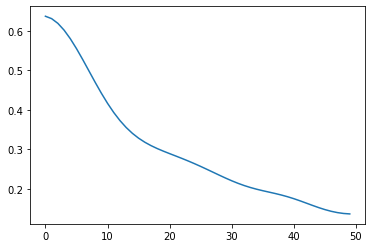

In [27]:
from matplotlib import pyplot as plt
x = [0.1000,2000,3000,4000,5000]
plt.plot(loss_list[0::100])
plt.show()

from scipy.ndimage import gaussian_filter1d

a = np.array(loss_list[0::100])
a = a.astype(float)
y_smoothed = gaussian_filter1d(a, sigma=5)
plt.plot(np.arange(50),y_smoothed)

In [16]:
from sklearn.metrics import classification_report
label_list=[]
true_list=[]
for batch in test_dataloader:
    x, y = batch
    logit = model(x)
    y = y.detach().numpy()
    logit = logit.detach().numpy()
    logit = np.where(logit <= 0.5, 0, logit)
    logit = np.where(logit > 0.5, 1, logit)
    logit= logit.squeeze()
    label_list.append(logit)
    true_list.append(y)
    print(classification_report(y_true = y, y_pred = logit))

              precision    recall  f1-score   support

           0       0.89      0.86      0.88      1226
           1       0.82      0.85      0.83       895

    accuracy                           0.86      2121
   macro avg       0.85      0.86      0.85      2121
weighted avg       0.86      0.86      0.86      2121

              precision    recall  f1-score   support

           0       0.89      0.88      0.88      1175
           1       0.86      0.86      0.86       946

    accuracy                           0.87      2121
   macro avg       0.87      0.87      0.87      2121
weighted avg       0.87      0.87      0.87      2121

              precision    recall  f1-score   support

           0       0.88      0.87      0.87      1231
           1       0.82      0.83      0.83       890

    accuracy                           0.85      2121
   macro avg       0.85      0.85      0.85      2121
weighted avg       0.85      0.85      0.85      2121

              preci

In [17]:
torch.save(model, 'model_PJ.pt')

In [ ]:
label_array=(np.array(label_list))
import pickle

with open('PJ_test.pkl','wb') as f:
    pickle.dump(label_array, f)

In [ ]:
true_array=(np.array(true_list))
with open('PJ_test_label.pkl','wb') as f:
    pickle.dump(true_array, f)